# A Long-Term Memory Agent

- Author: [byoon](https://github.com/acho98)
- Design: []()
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-EMBEDDING/02-CacheBackedEmbeddings.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

## Overview
This tutorial explains how to implement an agent with long-term memory capabilities using LangGraph. The agent can store, retrieve, and use memories to enhance its interactions with users.

Inspired by Research
The concept of long-term memory in agents is inspired by papers like [MemGPT](https://memgpt.ai/) and is based on our own work. The agent extracts memories from chat interactions and stores them in a database.

Memory Representation
In this tutorial, "memory" is represented in two ways:

- Text Information: A piece of text generated by the agent.
- Structured Information: Knowledge about entities extracted by the agent, represented as (subject, predicate, object) knowledge triples.   
This structured memory can be read or queried semantically to provide personalized context during interactions with users.

Key Idea: Shared Memory Across Conversations   
The KEY idea is that by saving memories, the agent persists information about users that is SHARED across multiple conversations (threads), which is different from memory of a single conversation that is already enabled by LangGraph's [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/).

<img src="./assets/17-long-term-mem-agent.png" width="500">


By using long-term memory, the agent can provide more personalized and context-aware responses across different conversations.

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Defne vectorstore for memories](#define-vectorstore-for-memories)
- [Define state, nodes and edges](#define-state-nodes-and-edges)
- [Build the graph](#build-the-graph)
- [Run the agent](#run-the-agent)
- [Adding structed memories](#adding-structured-memories)


### References
- [LangGraph Persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints)
- [Lang-memgpt](https://github.com/langchain-ai/lang-memgpt)
- [InMemoryByteStore](https://python.langchain.com/api_reference/core/stores/langchain_core.stores.InMemoryByteStore.html)


## Environment-setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [ ]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_community",
        "langchain_openai",
        "langgraph",
        "tiktoken",
        "matplotlib",
        "networkx",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "TAVILY_API_KEY": "",
    },
)

Environment variables have been set successfully.


In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

False

In [5]:
from typing import List
import uuid
import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

## Define vectorstore for memories

We will define the vectorstore where our memories will be stored and retrieved based on the conversation context.   
Memories will be stored as embeddings and later looked up when needed.
In this tutorial, we will use an in-memory vectorstore to manage and store our memories efficiently.

In [6]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

### Define tools

Next, we will define our memory tools.  
We need one tool to store memories and another tool to search for the most relevant memory based on the conversation context.

In [7]:
def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")
    return user_id

@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

Additionally, let's give our agent ability to search the web using Tavily.

In [8]:
search = TavilySearchResults(max_results=1)
tools = [save_recall_memory, search_recall_memories, search]

## Define state, nodes and edges

Our graph state consists of two channels:

- Messages: Stores the chat history to maintain conversation context.
- Recall Memories: Holds contextual memories that are retrieved before calling the agent and included in the system prompt.

This structure ensures relevant information is available for better responses.


In [9]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [10]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

The purpose of each function is as follows:
- `agent()`: Generates a response using GPT-4o with recalled memories and tool integration.
- `load_memories()`: Retrieves relevant past memories based on the conversation history.
- `route_tools()`: Determines whether to use tools or end the conversation based on the last message.

In [11]:
model = ChatOpenAI(model_name="gpt-4o")
model_with_tools = model.bind_tools(tools)
tokenizer = tiktoken.encoding_for_model("gpt-4o")

def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }

def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }

def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

## Build the graph

Our agent graph will be very similar to a simple ReAct agent.  
The only key difference is that we add a node to load memories before calling the agent for the first time.

In [12]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

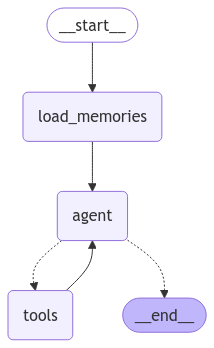

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Run the agent
Let's run the agent for the first time and tell it some information about the user.

In [14]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)
        print("\n")

Note: we're specifying `user_id` to save memories for a given user.

In [ ]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is Polar bear")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Nice to meet you, Polar Bear! How can I assist you today?




You can see that the agent saved the memory about user's name.  
Let's add some more information about the user.

In [16]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_kcUeAsdkjyeEGo7kukZoRUMe)
 Call ID: call_kcUeAsdkjyeEGo7kukZoRUMe
  Args:
    memory: Polar Bear loves pizza.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Polar Bear loves pizza.


Update from node: agent
================================== Ai Message ==================================

That's great to hear! Pizza is a delicious choice. Do you have a favorite type of pizza or any toppings you particularly enjoy?




In [17]:
for chunk in graph.stream(
    {"messages": [("user", "pepperoni!")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Polar Bear loves pizza.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_mdtowGoUTb7N75AI4eJgQvcs)
 Call ID: call_mdtowGoUTb7N75AI4eJgQvcs
  Args:
    memory: Polar Bear's favorite pizza topping is pepperoni.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Polar Bear's favorite pizza topping is pepperoni.


Update from node: agent
================================== Ai Message ==================================

Pepperoni is a classic and tasty choice! Do you have a favorite place to get pizza from, or do you enjoy making it at home?




In [18]:
for chunk in graph.stream(
    {"messages": [("user", "i also just moved to new york")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Polar Bear loves pizza.', "Polar Bear's favorite pizza topping is pepperoni."]}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_JxW02FHio010cKkgUAfm62Dg)
 Call ID: call_JxW02FHio010cKkgUAfm62Dg
  Args:
    memory: Polar Bear recently moved to New York.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Polar Bear recently moved to New York.


Update from node: agent
================================== Ai Message ==================================

That's exciting! New York is famous for its amazing pizza. Have you had a chance to explore any of the local pizzerias yet?




Now we can use the saved information about our user on a different thread. Let's try it out:

In [19]:
config = {"configurable": {"user_id": "1", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "where should i go for dinner?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Polar Bear loves pizza.', "Polar Bear's favorite pizza topping is pepperoni.", 'Polar Bear recently moved to New York.']}


Update from node: agent
================================== Ai Message ==================================

Considering you're in New York and have a love for pizza, why not try out some of the city's iconic pizzerias? You might enjoy a visit to places like Di Fara Pizza, Prince Street Pizza, or Joe's Pizza. They’re known for their delicious pepperoni pizzas, which I remember is your favorite topping! Does that sound like a plan, or are you in the mood for something different tonight?





Notice that the agent loads the most relevant memories before responding.  
In our case, it suggests dinner recommendations based on both food preferences and location.

Finally, let's use the search tool along with the conversation history and memory to find the location of a pizzeria.

In [20]:
for chunk in graph.stream(
    {"messages": [("user", "what's the address for joe's in greenwich village?")]},
    config=config,
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Polar Bear loves pizza.', "Polar Bear's favorite pizza topping is pepperoni.", 'Polar Bear recently moved to New York.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_PoUJZ0mWgZjqoiiQsI52uqrS)
 Call ID: call_PoUJZ0mWgZjqoiiQsI52uqrS
  Args:
    query: Joe's Pizza Greenwich Village address


Update from node: tools
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.joespizzanyc.com/", "content": "Established in 1975 by Joe Pozzuoli, who is originally from Naples, Italy, the birthplace of pizza, Joe's Pizza is a \"Greenwich Village institution\" offering the classic New York slice for over 47 years. First, we served our customers from our corner location at Bleecker and Carmine Street and now three doors down at 7 Carmine Street. At 75"}]


Up

## Adding structured memories

So far, we have stored memories as simple text, like "John loves pizza". This format works well when saving memories in a vector database.

However, if your application would benefit from other storage options—such as a graph database—we can modify the system to store memories in a more structured way.

Below, we update the `save_recall_memory` tool to accept a list of "knowledge triples" (3-part structures with a subject, predicate, and object), which can be stored in a knowledge graph. The model will then generate these structured representations when using its tools.

For now, we continue using the same vector database, but `save_recall_memory` and `search_recall_memories` can be further modified to work with a graph database.  
At this stage, we only need to update the `save_recall_memory` tool.

In [21]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

In [22]:
from typing_extensions import TypedDict

class KnowledgeTriple(TypedDict):
    subject: str
    predicate: str
    object_: str

@tool
def save_recall_memory(memories: List[KnowledgeTriple], config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    for memory in memories:
        serialized = " ".join(memory.values())
        document = Document(
            serialized,
            id=str(uuid.uuid4()),
            metadata={
                "user_id": user_id,
                **memory,
            },
        )
        recall_vector_store.add_documents([document])
    return memories

We can then compile the graph exactly as before:

In [24]:
tools = [save_recall_memory, search_recall_memories, search]
model_with_tools = model.bind_tools(tools)

# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [25]:
config = {"configurable": {"user_id": "3", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hi, I'm Sasako.")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Hello, Sasako! How can I assist you today?




In [26]:
for chunk in graph.stream(
    {"messages": [("user", "My friend Polar bear likes Pizza.")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_40xET1DW4j6CfjEUq8VzbPpP)
 Call ID: call_40xET1DW4j6CfjEUq8VzbPpP
  Args:
    memories: [{'subject': 'Sasako', 'predicate': 'has a friend who likes', 'object_': 'Pizza'}, {'subject': 'Sasako', 'predicate': "friend's name is", 'object_': 'Polar bear'}]


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

[{"subject": "Sasako", "predicate": "has a friend who likes", "object_": "Pizza"}, {"subject": "Sasako", "predicate": "friend's name is", "object_": "Polar bear"}]


Update from node: agent
================================== Ai Message ==================================

That's great to know, Sasako! Pizza is a popular favorite. Is there anything else you'd like to share or ask about?




As before, the memories generated from one thread are accessed in another thread from the same user:

In [27]:
config = {"configurable": {"user_id": "3", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "What food should I bring to Polar bear's party?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ["Sasako friend's name is Polar bear", 'Sasako has a friend who likes Pizza']}


Update from node: agent
================================== Ai Message ==================================

Since Polar bear likes pizza, bringing a variety of pizzas could be a great idea for the party. You might also consider bringing some complementary sides like garlic bread, salad, or a selection of drinks to go with the pizzas.




For illustrative purposes we can visualize the knowledge graph extracted by the model:

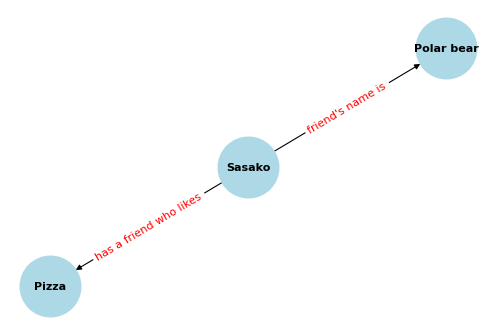

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

# Fetch records
records = recall_vector_store.similarity_search(
    "Sasako", k=2, filter=lambda doc: doc.metadata["user_id"] == "3"
)

# Plot graph
plt.figure(figsize=(6, 4), dpi=80)
G = nx.DiGraph()

for record in records:
    G.add_edge(
        record.metadata["subject"],
        record.metadata["object_"],
        label=record.metadata["predicate"],
    )

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()